# 0. Prerequisites
---

In [21]:
# Import Libraries
# ----------------
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import gdown
import json
import kagglehub
import IPython
import math
import random

In [2]:
# Load Dataset
# ------------
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print(f"Dataset GTZAN berhasil di-download di {path}")

# Tentukan path dataset GTZAN
dataset_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

Dataset GTZAN berhasil di-download di /kaggle/input/gtzan-dataset-music-genre-classification


# 1. Data Preprocessing
---

Setelah kita *load* dataset tersebut, kita akan melihat contoh data yang ada pada dataset tersebut.

In [3]:
sample ="/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00050.wav"
sample_data, sr=librosa.load(sample)
print(type(sample_data),type(sr))

<class 'numpy.ndarray'> <class 'int'>


`sr` merujuk pada sampling rate atau frekuensi sampel. Sampling rate adalah jumlah sampel audio yang diambil per detik. Ini mengindikasikan seberapa sering data audio diambil dari sinyal analog untuk dikonversi menjadi format digital. Semakin tinggi sampling rate, semakin banyak detail yang bisa ditangkap oleh file audio.

Contoh dari file audio tersebut dapat didengar di bawah ini.

In [4]:
librosa.load(sample,sr=45600)
IPython.display.Audio(sample_data,rate=sr)

Audio tersebut merupakan musik bergenre 'country' dengan waktu audio selama 30 detik.

## Visualisasi Audio

Dalam visualisasi audio, spectrogram dan waveform adalah dua cara yang umum digunakan untuk memvisualisasikan data audio:
- Waveform menunjukkan variasi amplitudo (tinggi-rendahnya gelombang) dari sinyal audio sepanjang waktu.
- Spectrogram menunjukkan bagaimana frekuensi dalam audio berubah seiring waktu.

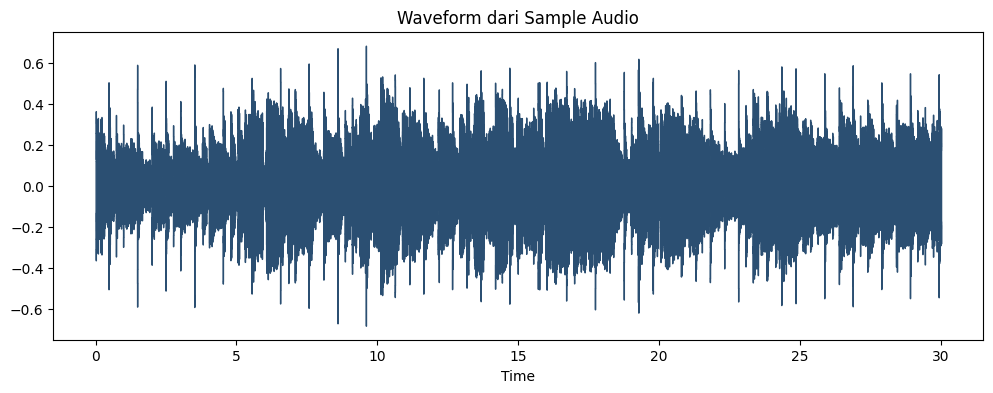

In [5]:
# Visualisasi Waveform
# --------------------
plt.figure(figsize=(12,4))
librosa.display.waveshow(sample_data,color="#2B4F72")
plt.title('Waveform dari Sample Audio')
plt.show()

<ipython-input-6-4384bf794ec8>:6: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')


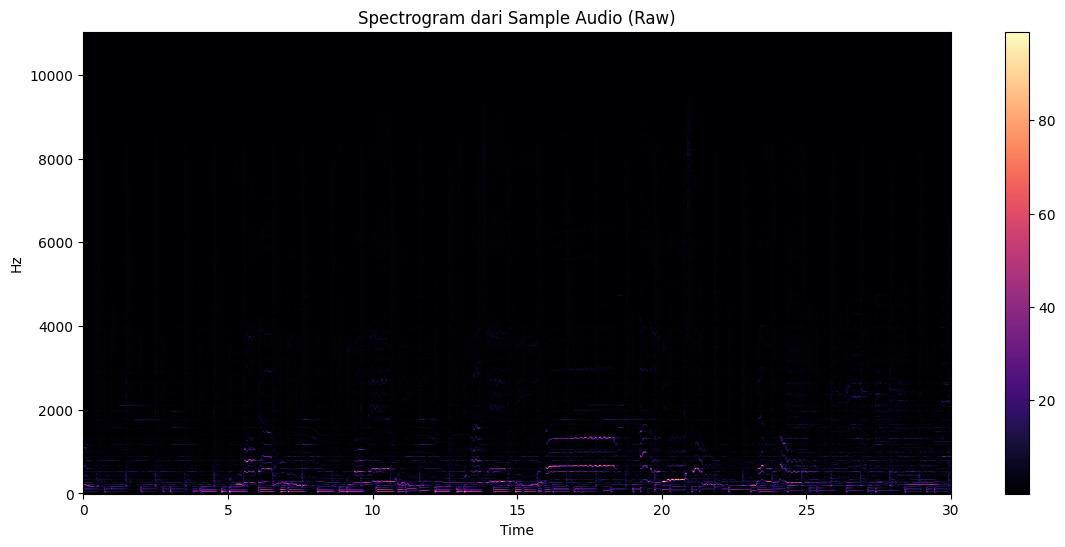

In [6]:
# Visualiasasi Spectrogram (Raw)
# ------------------------------
stft = librosa.stft(sample_data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.title('Spectrogram dari Sample Audio (Raw)')
plt.colorbar()

**Spektogram (Raw):**
Ini adalah representasi amplitudo dari sinyal audio dalam domain frekuensi. Karena amplitudo bisa sangat besar atau kecil, spektrum ini mungkin lebih sulit untuk dianalisis visualnya, terutama ketika ada perbedaan besar dalam intensitas sinyal.

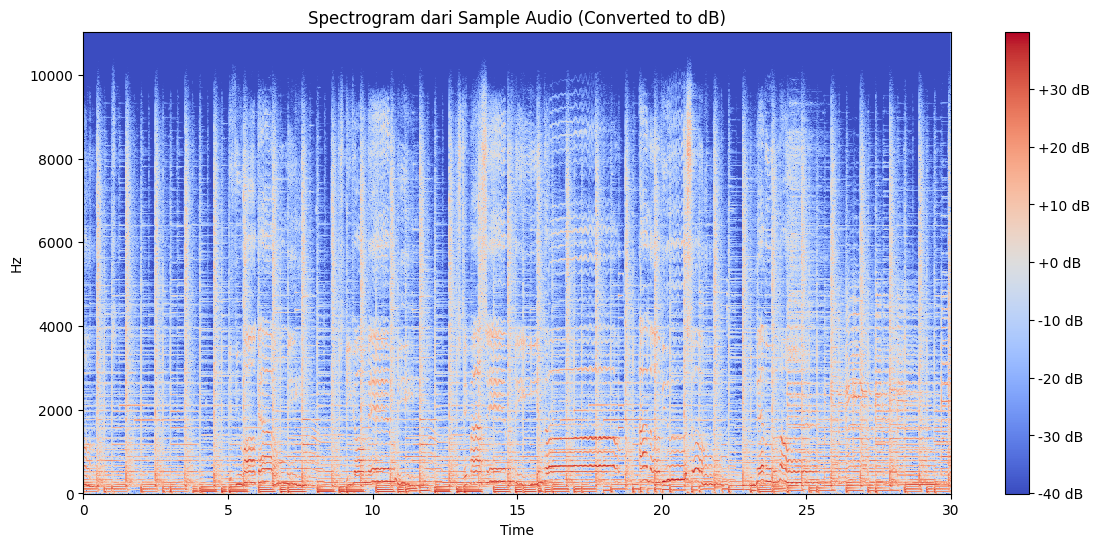

In [7]:
# Visualisasi Spectrogram dalam dB
# --------------------------------
stft=librosa.stft(sample_data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.title('Spectrogram dari Sample Audio (Converted to dB)')
plt.colorbar(format='%+2.0f dB')

**Spektogram (dalam dB):** Dalam jenis spektrogram ini, amplitudo pada spektrum dikonversi ke skala desibel (dB), yang mengukur rasio antara amplitudo sinyal dan referensi. Spektrogram dalam skala dB lebih mudah dilihat dan dibandingkan, karena perubahan amplitudo kecil pada nilai rendah lebih terlihat.

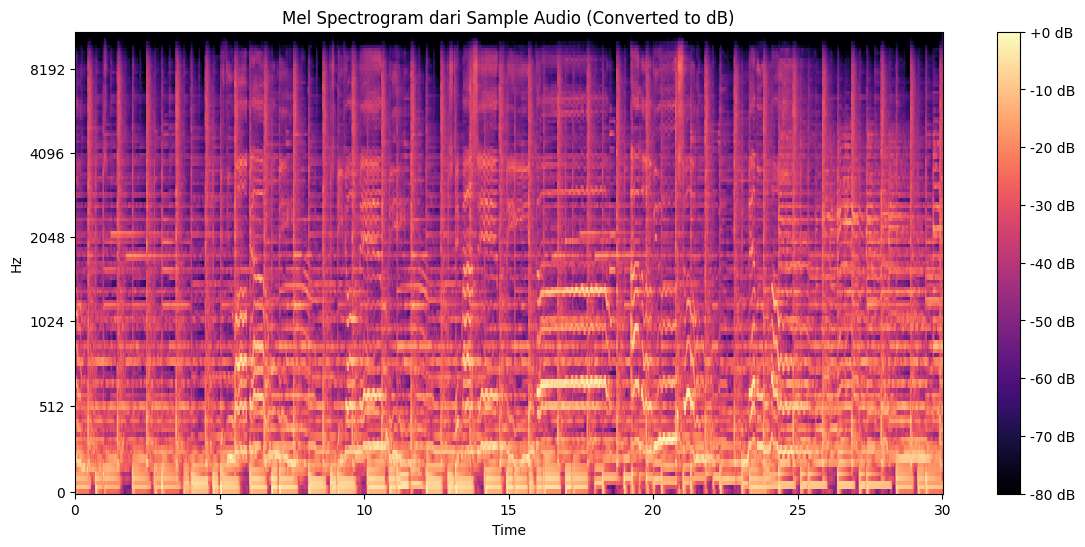

In [8]:
# Visualisasi Mel Spectrogram
# ---------------------------
mel_spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
plt.figure(figsize=(14,6))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram dari Sample Audio (Converted to dB)')
plt.colorbar(format='%+2.0f dB')
plt.show()

**Mel Spectrogram:** Representasi visual dari intensitas frekuensi audio yang disesuaikan dengan skala Mel, yang dirancang untuk meniru cara telinga manusia mendengar suara. Skala Mel mengubah frekuensi linier menjadi skala non-linier, memberikan resolusi lebih tinggi pada frekuensi rendah dan lebih rendah pada frekuensi tinggi. Hal ini membuat Mel Spectrogram lebih sesuai untuk aplikasi seperti pengenalan suara dan musik, karena lebih mencerminkan persepsi manusia terhadap suara.

Dalam proyek kali ini, kita akan menggunakan Mel Spectrogram untuk di-train menggunakan CNN.

## Ekstraksi Spektogram dari tiap Audio

Pada bagian ini, kita akan mengambil spektogram dari tiap file audio yang nantinya akan digunakan untuk training model. Sebenarnya, spektogram dari tiap audio telah disediakan pada dataset ini pada folder 'images_original'. Namun, kita tetap akan me-generate sendiri dengan library Librosa dan menggunakan Mel Spectrogram.

Data dari tiap audio akan diproses untuk diambil Mel Spectrogramnya dengan spesifikasi sebagai berikut:
- n_fft=2048: Nilai (Fast Fourier Transform) yang digunakan untuk mengonversi sinyal audio dari domain waktu ke domain frekuensi
- hop_length=512: Menentukan seberapa banyak sampel untuk "melompat" antara jendela FFT yang berurutan. Nilai 512 berarti jendela FFT akan bergerak sebanyak 512 sampel pada setiap langkahnya
- num_segments=5: Menentukan jumlah segmen dalam setiap lagu audio yang akan diekstraksi. Dengan nilai 5, setiap lagu akan dibagi menjadi 5 bagian atau segmen (dalam dataset terdapat 10 kategori dengan 100 sampel sehingga total dataset yang di-generate adalah 10x100x5=5000 sampel)
- n_mels=128: Merupakan jumlah filter Mel yang digunakan untuk menghitung Mel Spectrogram. Filter Mel ini didesain untuk meniru cara telinga manusia merespons frekuensi, dan 128 adalah jumlah filter yang digunakan untuk menganalisis spektrum frekuensi dalam Mel Scale
- batch_size=500: Menentukan jumlah file audio yang diproses dalam satu batch. Nilai 500 berarti kode akan memproses 500 file audio sekaligus sebelum menyimpan hasilnya ke file JSON dan melanjutkan ke batch berikutnya

**Catatan:** Pemprosesan dilakukan dalam beberapa batch karena sebelumnya ketika dilakukan tanpa batch sistem terus mengelami *crash* karena RAM yang tersedia (12GB) tidak cukup. Hasil dari pemprosesan tersebut disimpan dalam file JSON untuk efisiensi dan JSON memungkinkan pembagian data dalam beberapa file yang lebih kecil (batches)

In [11]:
# Ekstraksi Mel Spectogram dari tiap Audio Files
# ----------------------------------------------

SAMPLE_RATE = 22050
TRACK_DURATION = 30  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def extract_melspectrogram_from_dataset_in_batches(dataset_path, json_path_prefix, n_fft=2048, hop_length=512, num_segments=5, n_mels=128, batch_size=500):
    """Mengekstraksi Mel Spectrogram dari dataset musik secara bertahap (batch) dan menyimpannya ke dalam beberapa file JSON.
        :param dataset_path (str): Path ke folder dataset
        :param json_path_prefix (str): Prefix path untuk menyimpan Mel Spectrogram yang diekstraksi
        :param n_fft (int): Panjang jendela FFT untuk transformasi Fourier
        :param hop_length (int): Hop length untuk jendela bergerak dalam FFT
        :param num_segments (int): Jumlah segmen yang ingin dibagi untuk setiap track audio
        :param n_mels (int): Jumlah filter Mel untuk mel-spectrogram
        :param batch_size (int): Jumlah file audio yang akan diproses dalam satu batch
        :return: None
    """

    # Dictionary untuk menyimpan data Mel Spectrogram, label genre, dan mapping genre
    data = {
        "mapping": [],
        "labels": [],
        "melspectrogram": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mels_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # Variable to keep track of the batch number for file naming
    batch_number = 1

    # Loop untuk mengiterasi setiap folder genre dalam dataset
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # Pastikan kita sedang memproses folder genre
        if dirpath != dataset_path:

            # Simpan label genre (nama sub-folder) dalam mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nMemproses: {}".format(semantic_label))

            # Proses file dalam batch
            batch_files = []  # Initialize list to hold files for the current batch
            for f in filenames:
                if f.endswith('.wav'):
                    batch_files.append(os.path.join(dirpath, f))

                # Process the batch once it's filled
                if len(batch_files) == batch_size or (i == len(filenames)-1):  # Process batch if full or last batch
                    # Process current batch
                    for file_path in batch_files:
                        try:
                            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                        except Exception as e:
                            print(f"Terjadi kesalahan saat memuat {file_path}: {e}")
                            continue  # Skip this file if loading fails

                        # Process each segment of the audio file
                        for d in range(num_segments):
                            start = samples_per_segment * d
                            finish = start + samples_per_segment

                            # Ekstraksi Mel Spectrogram untuk segmen saat ini
                            melspec = librosa.feature.melspectrogram(y=signal[start:finish], sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                            melspec = librosa.power_to_db(melspec)  # Ubah ke skala dB untuk visualisasi yang lebih baik
                            melspec = melspec.T  # Transpose untuk mendapatkan dimensi time vs. mel filter bank

                            # Simpan hanya Mel Spectrogram yang valid
                            if len(melspec) == num_mels_vectors_per_segment:
                                data["melspectrogram"].append(melspec.tolist())
                                data["labels"].append(i)  # Label genre berdasarkan folder index
                                print(f"Memproses {file_path}, segmen: {d+1}")

                    # Clear the batch list after processing
                    batch_files.clear()

                    # Save results to a new JSON file
                    json_filename = f"{json_path_prefix}_part_{batch_number}.json"
                    with open(json_filename, "w") as fp:
                        json.dump(data, fp, indent=4)

                    print(f"Batch {batch_number} selesai dan data disimpan ke {json_filename}")

                    # Increment the batch number for the next file
                    batch_number += 1

                    # Clear the data dictionary after saving to avoid memory bloat
                    data["melspectrogram"].clear()
                    data["labels"].clear()

    print("\nProses batch selesai dan Mel Spectrogram telah disimpan ke beberapa file JSON.")

# Menetapkan path dataset dan file JSON output
dataset_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/'
json_path_prefix = 'data_10'  # Prefix untuk nama file JSON output

# Ekstraksi Mel Spectrogram dan simpan ke file JSON dalam batch
extract_melspectrogram_from_dataset_in_batches(dataset_path, json_path_prefix, n_fft=2048, hop_length=512, num_segments=5, n_mels=128, batch_size=100)


Memproses: disco
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segmen: 1
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segmen: 2
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segmen: 3
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segmen: 4
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segmen: 5
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00089.wav, segmen: 1
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00089.wav, segmen: 2
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00089.wav, segmen: 3
Memproses /kaggle/input/gtzan-

<ipython-input-11-5c4ebd12b8e6>:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Terjadi kesalahan saat memuat /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00041.wav, segmen: 1
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00041.wav, segmen: 2
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00041.wav, segmen: 3
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00041.wav, segmen: 4
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00041.wav, segmen: 5
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00038.wav, segmen: 1
Memproses /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00038.wav, segmen: 2
Memproses /kaggle/input/gtzan-dataset-music-genre-cla

Runtime proses ekstraksi Mel Spectrogram: ~10 menit pada Google Colab CPU (non-GPU) dengan RAM 12GB

# 2. Model Building
---

Pada bagian ini, proses pembangunan model CNN (Convolutional Neural Network) dilakukan untuk klasifikasi genre musik berdasarkan Mel Spectrogram. Berikut adalah langkah-langkah utama dalam proses ini:

1. **Pemrosesan Data**:
   - Dataset yang terdiri dari Mel Spectrogram dan label genre musik dimuat dari beberapa file JSON.
   - Data dibagi menjadi tiga set: pelatihan (training), validasi, dan uji (test). Pembagian dilakukan menggunakan `train_test_split` dari `sklearn` dengan proporsi train:test adalah 80:20.

2. **Pembangunan Model CNN**:
   - Model CNN dibangun menggunakan API Keras (`tensorflow.keras`).
   - Model terdiri dari beberapa lapisan konvolusional (Conv2D) diikuti dengan lapisan pooling dan normalisasi batch.
   - Setelah lapisan konvolusional, data di-flatten dan diteruskan ke lapisan dense untuk menghasilkan prediksi.
   - Model diakhiri dengan lapisan output menggunakan aktivasi softmax untuk klasifikasi multi-kelas (10 kelas genre musik).

3. **Kompilasi dan Pelatihan Model**:
   - Model dikompilasi menggunakan optimizer Adam dan loss function `sparse_categorical_crossentropy`
   - Model dilatih selama 30 epoch dengan ukuran batch 32

4. **Evaluasi dan Penyimpanan Model**:
   - Setelah pelatihan, model dievaluasi pada data uji untuk mendapatkan akurasi.
   - Model yang telah dilatih disimpan dalam file `.h5`

In [12]:
# Membaca Mel Spectrogram dari tiap File
# --------------------------------------

# List of JSON files (Part 1, Part 2, ..., Part 10)
DATA_PATHS = ["./data_10_part_1.json", "./data_10_part_2.json",
              "./data_10_part_3.json", "./data_10_part_4.json",
              "./data_10_part_5.json", "./data_10_part_6.json",
              "./data_10_part_7.json", "./data_10_part_8.json",
              "./data_10_part_9.json", "./data_10_part_10.json"]

def load_data(data_paths):
    """Memuat dataset pelatihan dari beberapa file JSON."""

    # Dictionary untuk menyimpan semua data yang digabungkan
    all_melspectrogram = []
    all_labels = []
    all_mapping = []

    for data_path in data_paths:
        with open(data_path, "r") as fp:
            data = json.load(fp)

        all_melspectrogram.extend(data["melspectrogram"])
        all_labels.extend(data["labels"])
        all_mapping.extend(data["mapping"])

    # Mengonversi list ke numpy array
    X = np.array(all_melspectrogram)
    y = np.array(all_labels)
    z = np.array(all_mapping)

    # Pastikan data ada
    print(f"Total samples: {len(X)}")
    print(f"Labels: {np.unique(y)}")  # Menampilkan label unik

    return X, y, z


def plot_history(history):
    """Menampilkan grafik akurasi dan loss untuk set pelatihan/validasi berdasarkan epoch
        :param history: Sejarah pelatihan model
        :return: Grafik akurasi dan error
    """

    fig, axs = plt.subplots(2)

    # Grafik akurasi
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Akurasi")

    # Grafik error
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Memuat data dan membaginya menjadi set pelatihan, validasi, dan uji.
    :param test_size (float): Persentase data yang dialokasikan untuk test set
    :param validation_size (float): Persentase dari train set yang dialokasikan untuk validasi
    :return: X_train, X_validation, X_test, y_train, y_validation, y_test, z
    """

    # Memuat data dari beberapa file JSON
    X, y, z = load_data(DATA_PATHS)

    # Membagi data menjadi train, validation, dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Menambahkan dimensi untuk set input
    X_train = X_train[..., np.newaxis]  # (samples, height, width, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z

In [13]:
# Pembangunan Model CNN
# ----------------------

def build_model(input_shape):
    """Membangun model CNN
    :param input_shape (tuple): Bentuk input data
    :return: model: CNN model
    """

    # Membangun topologi jaringan
    model = keras.Sequential()

    # Lapisan konvolusional pertama
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Lapisan konvolusional kedua
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Lapisan konvolusional ketiga
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Flatten output dan beri ke lapisan dense
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # Lapisan output
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [14]:
def predict(model, X, y, z):
    """Memprediksi sebuah sample menggunakan model yang telah dilatih
    :param model: Model yang telah dilatih
    :param X: Data input
    :param y (int): Target
    """

    # Menambahkan dimensi pada input data untuk sample - model.predict() mengharapkan array 4D dalam kasus ini
    X = X[np.newaxis, ...]  # Bentuk array (1, 130, 13, 1)

    # Melakukan prediksi
    prediction = model.predict(X)

    # Mendapatkan indeks dengan nilai maksimum
    predicted_index = np.argmax(prediction, axis=1)

    # Mendapatkan label untuk target dan prediksi
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

Total samples: 4993
Labels: [ 1  2  3  4  5  6  7  8  9 10]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 257, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 129, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 129, 63, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 61, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 30, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       983,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 997,834 (3.81 MB)

 Trainable params: 997,642 (3.81 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3091 - loss: 2.0753 - val_accuracy: 0.3164 - val_loss: 2.4009
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6076 - loss: 1.1658 - val_accuracy: 0.5688 - val_loss: 1.2852
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.7422 - loss: 0.7583 - val_accuracy: 0.6809 - val_loss: 0.9605
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8067 - loss: 0.5499 - val_accuracy: 0.7210 - val_loss: 0.8778
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.8844 - loss: 0.3978 - val_accuracy: 0.7263 - val_loss: 0.8773
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9113 - loss: 0.2887 - val_accuracy: 0.7316 - val_loss: 0.8730
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9402 - loss: 0.2143 - val_accuracy: 0.7343 - val_loss: 0.8339
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.9573 - loss: 0.1622 - val_accuracy: 0.7463 - v

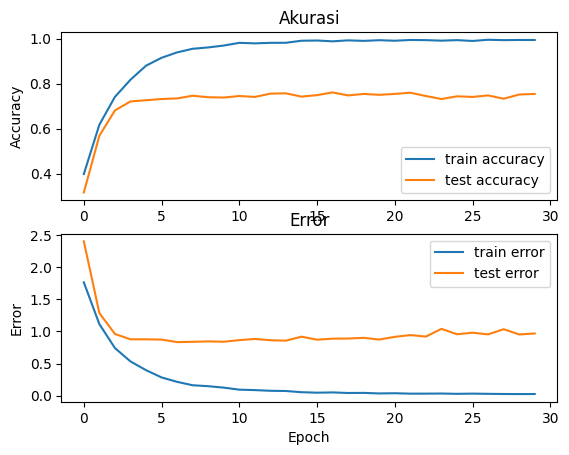

Model telah disimpan ke 'cnn_music_genre_classification.h5'


In [17]:
# CNN Model Training
# ------------------

# Mendapatkan train, validation, dan test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.2, 0.2)

# Membuat model CNN
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Input shape berdasarkan dimensi data latih
model = build_model(input_shape)

# Menyusun model (compile model)
optimiser = keras.optimizers.Adam(learning_rate=0.0001)  # Menggunakan Adam dengan learning rate kecil
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy untuk label numerik
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# Adjust labels to be in the range [0, 9]
y_train = y_train - 1
y_validation = y_validation - 1
y_test = y_test - 1

# Then continue with the rest of your code
history = model.fit(X_train, np.clip(y_train, 0, 10),
                    validation_data=(X_validation, y_validation),
                    batch_size=32,  # Ukuran batch 32
                    epochs=30)  # Melatih selama 30 epoch

# Menampilkan grafik akurasi dan error untuk data pelatihan dan validasi
plot_history(history)

# Menyimpan model ke file .h5
model.save('cnn_music_genre_classification.h5')  # Ganti nama file sesuai keinginan Anda
print("Model telah disimpan ke 'cnn_music_genre_classification.h5'")

Runtime proses training: ~100 menit pada Google Colab CPU (non-GPU) dengan RAM 12GB

# 3. Model Evaluation
---

Pada bagian ini, model yang telah di-train sebelumnya, dimuat dan dievaluasi menggunakan test dataset. Proses evaluasi menghasilkan nilai *test loss* dan *test accuracy* yang mencerminkan seberapa baik model dalam mengklasifikasikan data musik pada data yang belum dilihat sebelumnya.

Setelah itu, akan dibandingkan pula test vs. predicted output dari model tersebut berdasarkan Mel Spectrogram yang di-generate.

In [ ]:
# Berikut merupakan model yang sudah di-train berikutnya. Kita dapat langsung menggunakan model ini jikta tidak ingin melakukan training dari awal
# url = "https://drive.google.com/uc?id=19hX1psCfwAGor0ZBH-z6CYFdFGuIZ8QT"
# output = "cnn_music_genre_classification_30.h5"
# gdown.download(url, output)
#
# model = load_model('cnn_music_genre_classification_30.h5')

Downloading...
From: https://drive.google.com/uc?id=18nVTrGufzliMB_OMIjA6qxL-bP0wzidv
To: /content/cnn_music_genre_classification_uploaded.h5
100%|██████████| 12.0M/12.0M [00:00<00:00, 60.9MB/s]


'cnn_music_genre_classification_uploaded.h5'

In [18]:
# Load model yang sudah di-train sebelumnya
model = load_model('cnn_music_genre_classification.h5')

In [19]:
# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

40/40 - 17s - 424ms/step - accuracy: 0.7430 - loss: 0.9441

Test accuracy: 0.7429943680763245


Berdasarkan evaluasi tersebut, berdasarkan metriks akurasi, model memperoleh skor sebesar 0.743%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


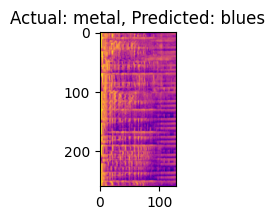

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


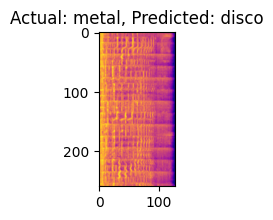

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


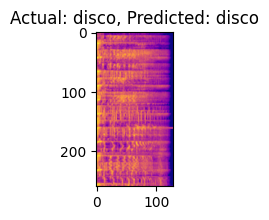

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


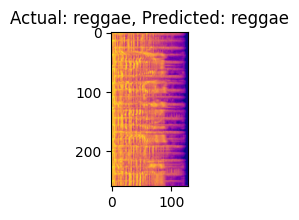

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


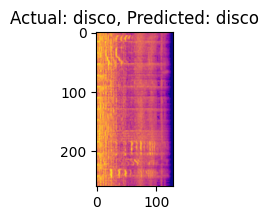

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


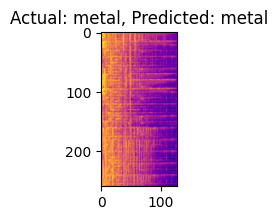

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


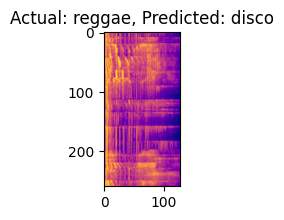

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


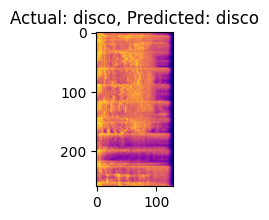

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


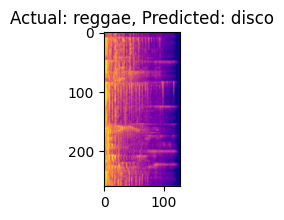

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


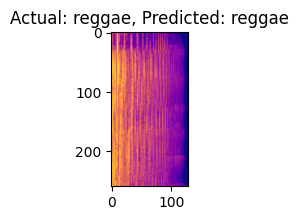

In [23]:
# Actual vs. Predicted Label berdasarkan Mel Spectrogram
# ------------------------------------------------------
np.random.seed(10121072)  # Seed untuk numpy
tf.random.set_seed(10121072)  # Seed untuk TensorFlow/Keras

# Actual vs. Predicted Label berdasarkan Mel Spectrogram
# ------------------------------------------------------
num_samples = 10

for i in range(num_samples):
    plt.figure(figsize=(2, 2))
    plt.imshow(X_test[i].reshape(X_test[i].shape[0], X_test[i].shape[1]), cmap='plasma')
    plt.title(f"Actual: {z[y_test[i]]}, Predicted: {z[np.argmax(model.predict(X_test[i][np.newaxis, ...]))]}")
    plt.show()

Berdasarkan data actual vs. predicted tersebut, model dapat memprediksi 6/10 data dengan benar. Tentunya dengan bertambahnya sampel, nilai prediksi yang benar akan semakin mendekati test accuracy yakni sekitar 74%

## Kesimpulan

Berdasarkan hasil tersebut, kita telah berhasil membuat model CNN yang menerima input berupa Mel Spectrogram dari suatu audio dan mengklasifikasikannya ke dalam beberapa kategori. **Model telah berhasil memperoleh skor yang cukup baik (74%) dan berada di rentang rerata skor yang dihasilkan oleh Model CNN untuk dataset yang sama.**

Namun, nilai akurasi tersebut masih di bawah requirements pada tugas kali ini, yakni 80%. Beberapa update model tersebut telah dilakukan tetapi masih *stuck* di bawah 80%. Karena *time constraint* terutama waktu training yang cukup lama, beberapa cara dapat dilakukan untuk meningkatkan akurasi model tersebut (namun belum diaplikasikan):
- **Augmentasi Data Audio**: menambahkan variasi pada data audio seperti mengubah nada, mempercepat/lambat tempo, menambahkan noise, etc.
- **Optimisasi Arsitektur Model**: mengubah/menambah lapisan pooling, menggunakan arsitektur ResNet, dan hyperparameter tuning lebih lanjut
- **Analisis Lebih Lanjut:** secara pengamatan sekilas, beberapa genre mungkin lebih sering mengalami salah prediksi dibandingkan genre lainnya. Analisis penyebabnya dan solusinya


